# Diamond EP Grouping by Resolution Limit - Feature Selection


Try to identify which features help model, and try to leave out uninformative features

In [2]:
import sys
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

Previously saw that SHELXC RPIM/RANOM are highly intercorrelated - see if they can be summarised into a single feature.

DIALS


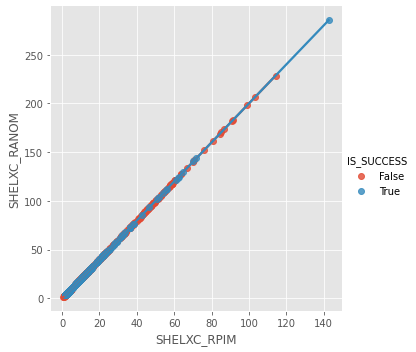

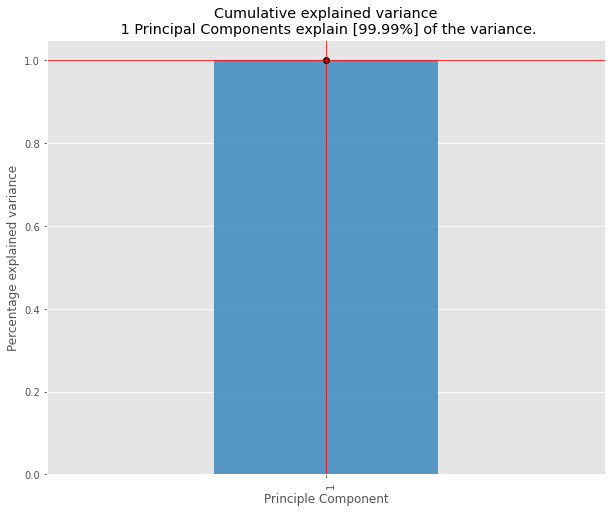

Normal
> F1 Score: 68.04% +- 2.95%
> MCC: 54.61% +- 3.96%
PCA
> F1 Score: 66.12% +- 3.25%
> MCC: 52.12% +- 4.38%
Remove
> F1 Score: 66.03% +- 3.56%
> MCC: 52.32% +- 4.83%


<Figure size 432x288 with 0 Axes>

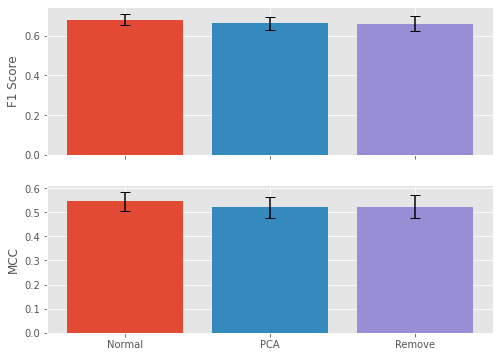

3DII


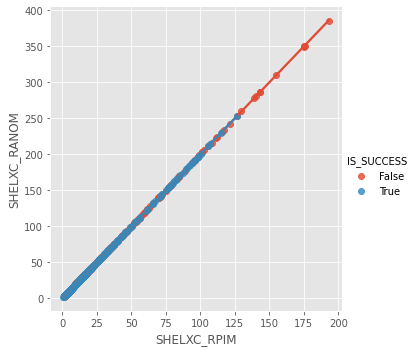

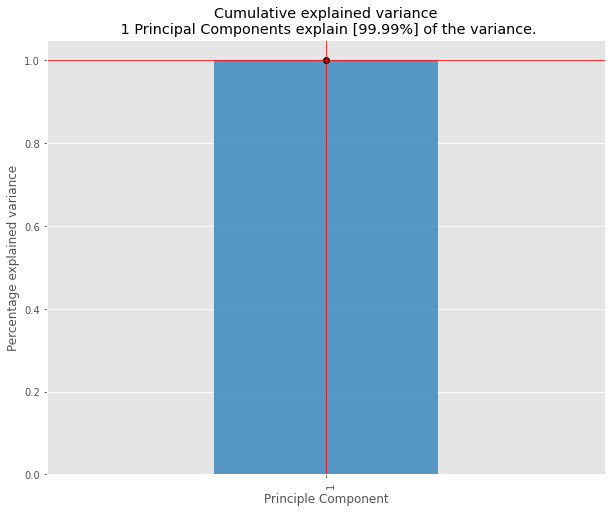

Normal
> F1 Score: 71.87% +- 0.58%
> MCC: 41.54% +- 1.04%
PCA
> F1 Score: 70.33% +- 0.78%
> MCC: 38.67% +- 2.27%
Remove
> F1 Score: 71.49% +- 0.73%
> MCC: 41.31% +- 1.14%


<Figure size 432x288 with 0 Axes>

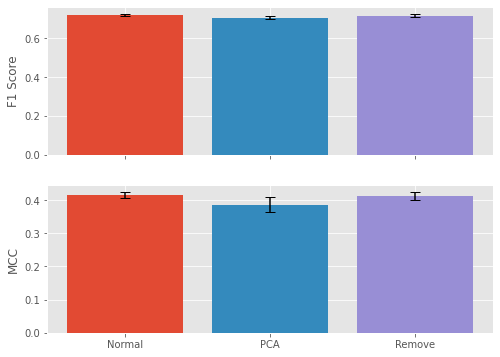

In [69]:
import seaborn as sns
from pca import pca as PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform, sem
mcc = make_scorer(matthews_corrcoef)


seed = 1
n_iter = 5

for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    x_part = x[["SHELXC_RPIM", "SHELXC_RANOM"]]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    sns.lmplot(data=union_part, x="SHELXC_RPIM", y="SHELXC_RANOM", hue="IS_SUCCESS")
    plt.show()
    
    # do PCA on two features
    pca = PCA(normalize=True, n_components=1)
    new = pca.fit_transform(x_part, verbose=2)
    pca.plot()
    
    # get new x
    x_new = x.drop(["SHELXC_RPIM", "SHELXC_RANOM"], axis=1)
    x_pca = x_new.copy()
    x_pca["PCA_RPIM/RANOM"] = new["PC"]
    
    # create model
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # prepare figure
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    
    for i, (x_part, name) in enumerate(zip([x, x_pca, x_new], ["Normal", "PCA", "Remove"])):
        print(name)
    
        # split into train and test datasets and train model
        #X_train, X_test, y_train, y_test = train_test_split(x_part, y, stratify=y, test_size=.2, random_state=seed)
        #forest.fit(X_train, y_train)
        #y_pred = forest.predict(X_test)
        f1s = cross_val_score(forest, x_part, y, scoring='f1', cv=5, n_jobs=-1)
        mccs = cross_val_score(forest, x_part, y, scoring=mcc, cv=5, n_jobs=-1)
        f1_val, f1_err = f1s.mean(), sem(f1s)
        mcc_val, mcc_err = mccs.mean(), sem(mccs)
        
        ax1.bar(i, f1_val, yerr=f1_err, capsize=5)
        ax2.bar(i, mcc_val, yerr=mcc_err, capsize=5)
        
        print(f"> F1 Score: {f1_val:.2%} +- {f1_err:.2%}\n"
              f"> MCC: {mcc_val:.2%} +- {mcc_err:.2%}")
    
    # labels
    ax1.set_ylabel("F1 Score")
    ax2.set_ylabel("MCC")
    ax2.set_xticks([0, 1, 2])
    ax2.set_xticklabels(["Normal", "PCA", "Remove"])
    
    plt.show()

DIALS
(1201, 34) (1201,)


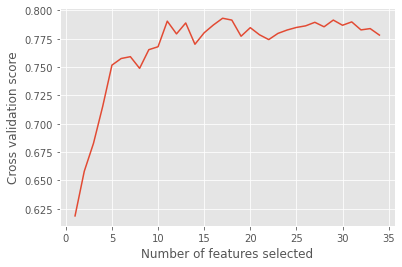

------------------------------------------------------------
3DII
(1450, 34) (1450,)


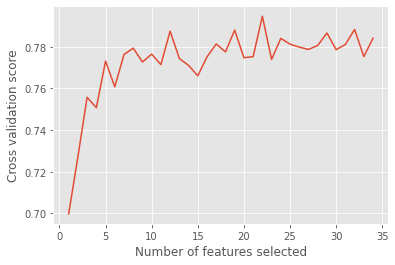

------------------------------------------------------------


In [32]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, train_test_split



for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    print(x.shape, y.shape)
    
    # create estimators
    seed = 1
    n_iter = 5
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced"))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed, error_score=0)
        
    # separate into train/test datasets and train model
    X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=seed)
    
    # select best features
    selector = RFECV(forest_search, cv=5, scoring="f1", importance_getter="best_estimator_.named_steps.clf.feature_importances_")
    selector.fit(X_train, y_train)
    
    # plot results
    plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score")
    plt.show()
    
    ranking = pd.Series(selector.ranking_, index=x.columns)
    print(ranking)
    print(f"Optimal number of features: {selector.support_}")
    
    print("-"*60)